In [1]:
import os
import pandas as pd
from datetime import datetime,date,time,timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import string
from scipy import ndimage
import scipy

0019[3190,4800],0047[340:1012]



In [2]:
#dia al azar
d=date(2017,3,1)
t=time(1,23,2)
t2=time(1,4,4)
dato1=datetime.combine(d,t)
dato2=datetime.combine(d,t2)



https://racelogic.support/01VBOX_Automotive/01General_Information/Knowledge_Base/VBO_file_format

In [3]:
base_dirEl='data_electrico'
data_fileEl='VBS__047.VBO'

base_dirG = 'Data'
data_fileG = 'VBOX0019.VBO'

# Funcion que lee unicamente los datos del kart electrico
def leerElectrico(base,nombre):
    with open(os.path.join(base,nombre),'r') as vboxdata:
        section = []

        dats=[]
        cols=[]

        for line in vboxdata:
            if line[0] == '[':
                section = str.replace(line, "\n","")
                continue
            if section == '[column names]':
                col_names =line.strip('\n')
                if col_names !="":
                    #print(col_names)
                    cols.append(col_names)
            if section =='[data]':
                linesplit=line.strip('\n').split(' ')
                linesplit=linesplit[:-1]   
                for idx,da in enumerate(linesplit): 
                    if idx==1:
                        #manejo de tiempos
                        hora=int(linesplit[1][0:2])
                        minuto=int(linesplit[1][2:4])
                        seg=int(linesplit[1][4:6])
                        mili=int(linesplit[1][7:])*10000
                        tiempo=time(hora,minuto,seg,mili)
                        linesplit[idx]=datetime.combine(d,tiempo)
                    else:
                        linesplit[idx]=float(linesplit[idx])
                dats.append(tuple(linesplit))



    datos=pd.DataFrame(dats,columns=cols)
    datos=datos.drop(['sats','longacc','latacc','temp','Vbat','batt-flags','batt-ai','batt.soc','heading'],axis=1)
    nuevonombre={'time':'Tiempo','lat':'Latitude','long':'Longitude','velocity':'Velocidad','height':'Altura'}
    datos.rename(columns=nuevonombre, inplace=True)
    return datos
#Funcion que lee los datos del kart a gasolina   
def leerGas(base,file_name):
    with open(os.path.join(base,file_name), 'r') as vboxdata:
        dats=[]
        cols=[]
        section=[]
        for line in vboxdata:
            if line[0] == '[':
                section = str.replace(line, "\n","")
                continue
            if section == '[column names]':
                cols = str.replace(line, "  \n","").split('  ')
                section = []
            if section == '[data]':
                linesplit = str.replace(line, " \n","").split(' ')
                
                for idx in range(len(linesplit)):
                    if idx==1:
                        #manejo de tiempo
                        hora=int(linesplit[1][0:2])
                        minuto=int(linesplit[1][2:4])
                        seg=int(linesplit[1][4:6])
                        mili=int(linesplit[1][7:])*10000
                        tiempo=time(hora,minuto,seg,mili)
                        linesplit[idx]=datetime.combine(d,tiempo)
                    else:
                        linesplit[idx]=float(linesplit[idx])
                dats.append(tuple(linesplit[:-1]))
                



    datos=pd.DataFrame(dats,columns=cols)
    datos=datos.drop(['sats','heading','vert-vel','pot event-1'],axis=1)
    nuevonombre={'time':'Tiempo','lat':'Latitude','long':'Longitude','velocity':'Velocidad','height':'Altura'}
    datos.rename(columns=nuevonombre, inplace=True)
    return datos

def leerdatos(base,nombre,tipo):
    if tipo == 'electrico':
        datos=leerElectrico(base,nombre)
    elif tipo=='gas':
        datos=leerGas(base,nombre)
    return datos
gas=leerdatos(base_dirG,data_fileG,'gas')
ele=leerdatos(base_dirEl,data_fileEl,'electrico')

inicialE=340
#finalE=1553
finalE=1352

inicialG=3190
finalG=7990
ele=ele[:][inicialE:finalE].reset_index().drop(['index'],axis=1)
t=[None]*len(ele.Tiempo)
t0=ele.Tiempo[0]
for i,tiempo in enumerate(ele.Tiempo):
   t[i]=(tiempo-t0).total_seconds()

ele.Tiempo=t

gas=gas[:][inicialG:finalG].reset_index().drop(['index'],axis=1)
t=[None]*len(gas.Tiempo)
t0=gas.Tiempo[0]
for i,tiempo in enumerate(gas.Tiempo):
   t[i]=(tiempo-t0).total_seconds()
gas.Tiempo=t
#Velocidad en m/s
gas.Velocidad=gas.Velocidad/3.6
ele.Velocidad=ele.Velocidad/3.6


Graficar la velocidad en busqueda del momento en el que se empieza a mover el kart

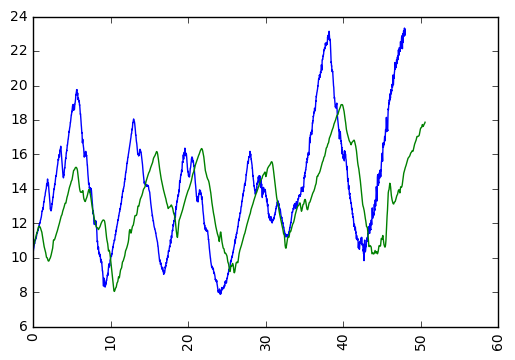

In [4]:
plt.plot(gas.Tiempo,gas.Velocidad)
plt.plot(ele.Tiempo,ele.Velocidad)
plt.xticks(rotation=90)
plt.show()

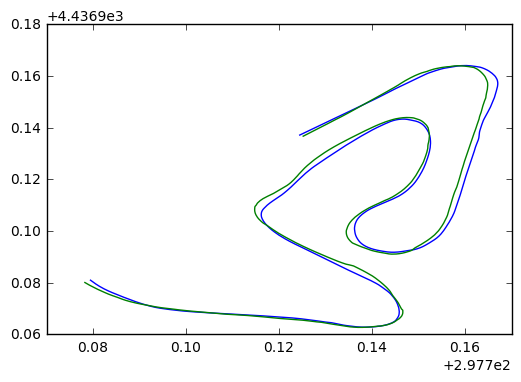

In [5]:
plt.plot(gas.Latitude,gas.Longitude)
plt.plot(ele.Latitude,ele.Longitude)
plt.show()

La anterior grafica muestra el recorrido que se estudiará. No es posible comparar una vuelta completa ya que como la toma de datos de estos karts fueron dias diferente el layout de la pista era diferente (el kart de gasolina tenia un recorrido más largo) y por ende esto no podrían dar una comparación justa para aspectos como tiempo de vuelta. 

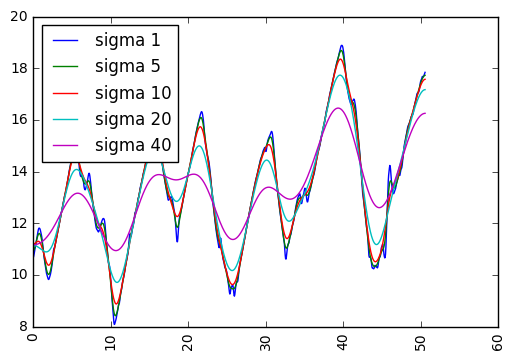

In [6]:
sigmas=[1,5,10,20,40]
vfiltros=[None]*len(sigmas)

for idx,des in enumerate(sigmas):
    vfiltros[idx]=ndimage.gaussian_filter1d(ele.Velocidad,sigma=des,order=0)
    plt.plot(ele.Tiempo,vfiltros[idx],label='sigma %d' % des)
    plt.legend(loc=2)
    plt.xticks(rotation=90)
    
plt.show()

Se decide usar el filtro de sigma = 10 ya que no cambia tanto con respecto al valor medido como lo hace sigma 40 y logra quitar ruido de la señal. A continuacion se compara este con respecto a 

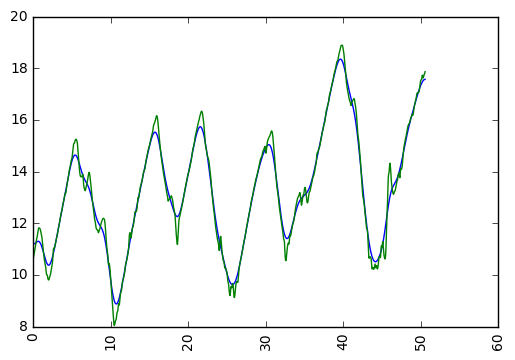

In [7]:
plt.plot(ele.Tiempo,vfiltros[2])
plt.plot(ele.Tiempo,ele.Velocidad)
plt.xticks(rotation=90)
plt.show()

Ahora que se ha escogido el grado del filtro es posible pasar las dos series por el filtro y luego calcular la distancia y la aceleración del recorrido

# Rendimiento de los Vehiculos

In [25]:
vf=vfiltros[2]
ele.Velocidad=vf
gas.Velocidad=ndimage.gaussian_filter1d(gas.Velocidad,sigma=20,order=0)


ele['Aceleracion']=np.gradient(vf)/0.05
gas['Aceleracion']=np.gradient(gas.Velocidad)/(gas.Tiempo[1]-gas.Tiempo[0])

ele['Distancia']=scipy.integrate.cumtrapz(ele.Velocidad,ele.Tiempo,initial=0)
gas['Distancia']=scipy.integrate.cumtrapz(gas.Velocidad,gas.Tiempo,initial=0)

Ya que se tienen todos los es posible empezar a comparar el desempeño de la media vuelta que tiene en comun los dos karts. 

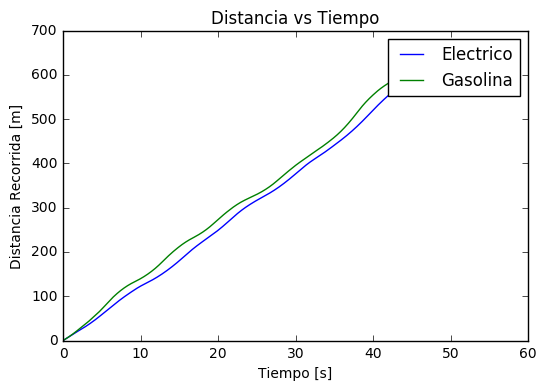

El tiempo del kart de gasolina para recorrer esta parte de la pista fue de: 47.99s
El tiempo del kart electrico para recorrer esta parte de la pista fue de: 50.55s



In [26]:
plt.plot(ele.Tiempo,ele.Distancia,label='Electrico')
plt.plot(gas.Tiempo,gas.Distancia,label='Gasolina')
plt.legend()
plt.title('Distancia vs Tiempo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Distancia Recorrida [m]')
plt.show()
print('El tiempo del kart de gasolina para recorrer esta parte de la pista fue de: %.2fs'%gas.Tiempo[len(gas)-1])
print('El tiempo del kart electrico para recorrer esta parte de la pista fue de: %.2fs'%ele.Tiempo[len(ele)-1])
print()

De esta grafica es posible ver que en todo momento el kart de Gasolina iría al frente del Kart de Gasolina. El kart electrico parece ir a una velocidad constante mientras que el kart de Gasolina varia mucho más. Se sospecha que esto se podra ver en la grafica de Velocidad. Adicionalmente la diferencia del tiempo para recorrer esta parte de la pista fue de 2 segundos. Lo cual es una diferencia significativa tomando en cuenta que solo se recorre aproximadamente la mitad de la pista. 

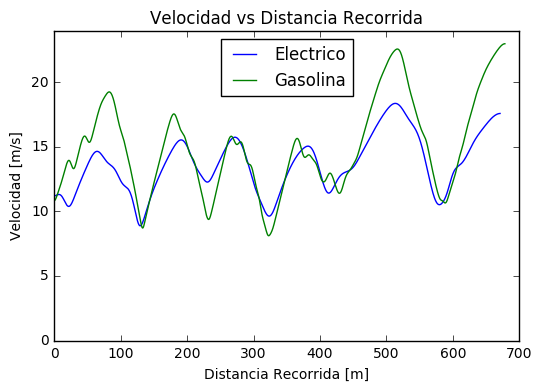

In [27]:
plt.plot(ele.Distancia,ele.Velocidad,label='Electrico')
plt.plot(gas.Distancia,gas.Velocidad,label='Gasolina')
plt.legend(loc=9)
plt.title('Velocidad vs Distancia Recorrida')
plt.xlabel('Distancia Recorrida [m]')
plt.ylabel('Velocidad [m/s]')
plt.ylim([0,24])
plt.show()

Esta Gráfica muestra que el kart de Gasolina generalmente iba más rapido (con la excepcion de cuando se frenaba (posiblemente en las curvas)). Esto explica porque este kart recorre la distancia en un menor tiempo. Es importante notar que ninguno de los dos Karts va más de 24 m/s. Es decir ninguno de estos llega a la velocidad máxima de aproximadamente 28 m/s para el caso del Kart Electrico. 
Por otro lado las fluctiaciones de la velocidad del Kart de Gasolina son mayores esto explica porque en la anterior grafica se observo que la linea no es tan para seria de Gasolina. 

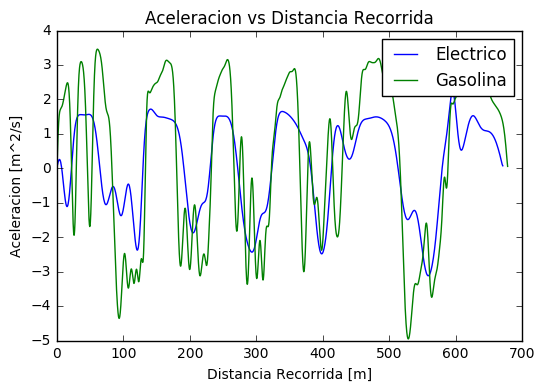

La aceleración máxima del kart eléctrico es de 2.22
La aceleración máxima del kart de gasolina es de 3.54


In [28]:
plt.plot(ele.Distancia,ele.Aceleracion,label='Electrico')
plt.plot(gas.Distancia,gas.Aceleracion,label='Gasolina')
plt.legend()
plt.title('Aceleracion vs Distancia Recorrida')
plt.xlabel('Distancia Recorrida [m]')
plt.ylabel('Aceleracion [m^2/s]')
plt.show()
print('La aceleración máxima del kart eléctrico es de %.2f'% max(ele.Aceleracion))
print('La aceleración máxima del kart de gasolina es de %.2f'% max(gas.Aceleracion))


De esta grafica se observa que claramente el kart de Gasolina tiene una fuerza mucho mayor y por ende alcanza aceleraciónes más grandes. El kart electrico alcanza aceleraciones de 2/3 en comparacion con las que alcanza el kart de Gasolina. Adicional a esto si se comparan estos resultados con los encontrados en el taller 2. Las aceleraciones del Kart electricos son mayores a las modeladas. Esto muestra que existe un error en el modelo. Probablmente las caracteristicas del kart tomadas para el programa anterior no corresponeden al kart real. Lo mismo ocurre con la aceleración de frenado en el cual el modelo lo sobre estima. 

# Desempeño de los Motores

Datos y Funciones del Kart de Combustion interna

In [29]:
# Datos Llantas tractivas 
rllG=0.139 # Radio geométrico de las llantas en traseras (m)
refcG=0.98*rllG # Radio efectivo llantas traseras (m)
rinG=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dpG=11.0 # Dientes del piñon
dplG=87.0 # Dientes del plato
ngG=dplG/dpG # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
rejeG=0.02 # Radio eje de las llantas (m)
mejeG=3.832 # Masa del eje (kg)

# Datos Kart general
masaG=140.0 # masa del Kart con piloto(kg)
g=9.81 # Gravedad (m/s)
wG=masaG*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rhoG=1.1955 # densidad del aire (kg/m^3)
dllG=0.975 # Distancia entre ejes de llantas delanteras (m)
aljG=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
afG=(dllG*aljG)/2 # Area Frontal Kart (m^2)
cdG=0.89 # Coeficiente de Arrastre Kart
vwG=0.0 # velocidad del viento (m/s)
thetaG=0.0 # Angulo carretera

# Inercias
iiG=0.01 # Inercia motor de combustión 

mlltG=1.43 # Masa llantas traseras (kg)
mlldG=1.20 # Masa llantas delanteras (kg)
rlldG=0.129 # Radio llantas delanteras (m)
rindG=0.0631 # Radio rin llantas delanteras (m)
mbtG=0.7*mlltG # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdtG=0.3*mlltG # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbdG=0.7*mlldG # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mddG=0.3*mlldG # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illdG=(mbdG*rlldG)+(mddG*(rlldG**2-rindG**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illtG=(mbtG*rllG)+(mdtG*(rllG**2-rinG**2))/2 # Inercia 1 llanta trasera (kg-m^2)

rpiG=0.01525 # Radio Piñon (m)
rplaG=0.10775 # Radio Plato (m)
rhoacG=7850.0 # Densidad del Acero (kg/m^3)
bpiG=0.01 # Ancho piñon (m)
bplaG=0.01 # Ancho plato (m)
vpiG= bpiG*np.pi*rpiG**2 # Volumen del piñon (m^3)
vplaG=bplaG*np.pi*rplaG**2 # Volumen del plato (m^3)
mpiG=rhoacG*vpiG # Masa del piñon (kg)
mplaG=rhoacG*vplaG # Masa del plato (kg)
igG=((mpiG*(rpiG**2))/2)+((mplaG*(rplaG**2))/2) # Inercia de la transmisión (kg-m^2)

iejeG=(mejeG*rejeG**2)/2 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
aG=0.2036 # Distancia del centro de gravedad al eje de la llanta trasera (m)
lG=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
hG=0.0960 # Altura del centro de gravedad del kart con respecto al piso (m)



def frodaduraG(vx,ax):
    wr=wG*((aG/lG)+(ax/g*(hG/lG))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx*3.6/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    # fr=C*((mllt*g)/(rllt*2))*sqrt(ht/bllt)
    # ht=0.0739 # Altura del neumático (m)
    # bllt=0.209 # Ancho del neumático (m)
    # C= # Constante del material de la llanta
    return wr*fr*np.cos(thetaG) # (N)

# Fuerza del ángulo de la carretera
def finclinacionG(theta):
    return wG*np.sin(theta) # (N)

# Fuerza de arrastre
def farrastreG(vx):
    return (1/2.0)*rhoG*afG*cdG*(vx+vwG)**2 # (N)

# Fuerza de tracción, Torque del Motor
def ftraccionG(ax,Fg,Fw,Fr):
    # Ft=((ti*ng*etaf)/refc)-(((ii-ig)*ng^2)+ieje+illd*2+illt*2)*(ax/(refc^2)) # (N)
    return masaG*ax+Fg+Fw+Fr

def torquemotorG(ax,Ft):
    return (Ft+(((iiG-igG)/(ngG**2))+iejeG+illdG*2+illtG*2)*(ax/(refcG**2)))*(refcG/(ngG*etaf)) # Torque del motor (Nm)


# Velocidad angular del motor
def vangularmotorG(vx):
    return (vx*ngG)/refcG # (rad/s)


Datos y Funciones del Kart Electrico

In [30]:
rllE=0.175 # Radio geometrico de las llantas traseras [m]
refcE=0.98*rllE # Radio efectivo llantas traseras [m]
rinE=0.0631  #Radio interno de neum'atico [m]

dpE=20 #Dientes del piñon
dplE=64 #Dientes del plato(eje)
ngE=dplE/dpE #Relacion de Transmision 
etaf=0.95 #Eficiencia de transmision


rejeE=0.02  #Radio eje de las llantas [m]
mejeE=3.832 #Masa del eje (kg)


masaE=152.0 #Masa kart [kg]
g=9.81 #Gravedad [m/s]
wE=masaE*g #Peso del kart [N]

rhoE=1.1955 # densidad del aira [kg/m^3]
dllE=0.975 #Distancia entre llantas delanteras (m)
aljE=0.88 #Altura con el piloto sentado en el kart (estatura 1.68 m )[m]
afE=(dllE*aljE)/2 #Area frontal kart [m^2]
#Se asume el area del kart como un triangulo
cdE=0.89 #Coeficiente de Arrastre del Kart
vwE=0.0 #Velocidad del viento[m/s]
thetaE=0.0 #angulo carretera


iiE=5.2E-3 #Inercia Motor de Combustión 

mlltE=1.43 #Masa de las llantas traseras [kg]
mlldE= 1.20 # Masa llantas delanteras [kg]
rlldE=0.129 #Radio de las llantas delanteras [m]
rindE=0.0631 #Radio rin llantas delanteras [m]
refdE=0.98*rlldE #Radio efectivo llanta delantera
mbtE=0.7*mlltE # La masa total que pesa la parte "banda" de la llanta trasera [kg]
mdtE=0.3*mlltE # La masa total que pesa la parte "disco" de la llanta trasera [kg]
mbdE=0.7*mlldE # La masa total que pesa la parte "banda" de la llanta delantera [kg]
mddE=0.3*mlldE # La masa total que pesa la parte "disco" de la llanta delantera[kg]
illdE=(mbdE*rlldE)+(mddE*(rlldE**2-rindE**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illtE=(mbtE*rllE)+(mdtE*(rllE**2-rinE**2))/2 # Inercia 1 llanta trasera (kg-m^2)

rpiE=0.01525#Radio piñon [m]
rplaE=0.04096 #[m]
rhoacE=7850.0 # Densidad del Acero (kg/m^3)
bpiE=0.01 # Ancho piñon (m)
bplaE=0.02 # Ancho plato (m)
vpiE= bpiE*np.pi*rpiE**2 # Volumen del piñon (m^3)
vplaE=bplaE*np.pi*rplaE**2 # Volumen del plato (m^3)
mpiE=rhoacE*vpiE # Masa del piñon (kg)
mplaE=rhoacE*vplaE # Masa del plato (kg)
igE=((mpiE*(rpiE**2))/2.0)+((mplaE*(rplaE**2))/2.0) # Inercia de la transmisión (kg-m^2)

iejeE=(mejeE*rejeE**2)/2.0 # Inercia del eje de las llantas (kg-m^2)



# Resistencia a la rodadura
aE=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera [m]
lE=1.0063 # Distancia de eje de las llantas traseras y delanteras [m]
hE=0.07478 # Altura del centro de gravedad del kart con respecto al piso [m]

def frodaduraE(vx,ax):
    wr=wE*((aE/lE)+(ax/g*(hE/lE))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx*3.6/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    # fr=C*((mllt*g)/(rllt*2))*sqrt(ht/bllt)
    # ht=0.0739 # Altura del neumático (m)
    # bllt=0.209 # Ancho del neumático (m)
    # C= # Constante del material de la llanta
    return wr*fr*np.cos(thetaE) # (N)

# Fuerza del ángulo de la carretera
def finclinacionE(theta):
    return wE*np.sin(theta) # (N)

# Fuerza de arrastre
def farrastreE(vx):
    return (1/2.0)*rhoE*afE*cdE*(vx+vwE)**2 # (N)

# Fuerza de tracción, Torque del Motor
def ftraccionE(ax,Fg,Fw,Fr):
    # Ft=((ti*ng*etaf)/refc)-(((ii-ig)*ng^2)+ieje+illd*2+illt*2)*(ax/(refc^2)) # (N)
    return masaE*ax+Fg+Fw+Fr

def torquemotorE(ax,Ft):
    return (Ft+(((iiE-igE)/(ngE**2))+iejeE+illdE*2+illtE*2)*(ax/(refcE**2)))*(refcE/(ngE*etaf)) # Torque del motor (Nm)


# Velocidad angular del motor
def vangularmotorE(vx):
    return (vx*ngE)/refcE # (rad/s)



Calculo exacto de Torque, Velocidad y Potencia del motor

In [31]:
#Fuerzaas velocidades y potencias Gasolina
FgG=frodaduraG(gas.Velocidad,gas.Aceleracion)
FwG=finclinacionG(thetaG)
FrG=farrastreG(gas.Velocidad)
FtG=ftraccionE(gas.Aceleracion,FgG,FwG,FrG)
TmotorG=torquemotorG(gas.Aceleracion,FtG)
omegaG=vangularmotorG(gas.Velocidad)
PG=TmotorG*omegaG
rpmG=omegaG/(2*np.pi)*60

#Fuerzaas velocidades y potencias Gasolina
FgE=frodaduraE(ele.Velocidad,ele.Aceleracion)
FwE=finclinacionE(thetaG)
FrE=farrastreE(ele.Velocidad)
FtE=ftraccionE(ele.Aceleracion,FgE,FwE,FrE)
TmotorE=torquemotorG(ele.Aceleracion,FtE)
omegaE=vangularmotorE(ele.Velocidad)
PE=TmotorE*omegaE
rpmE=omegaE/(2*np.pi)*60

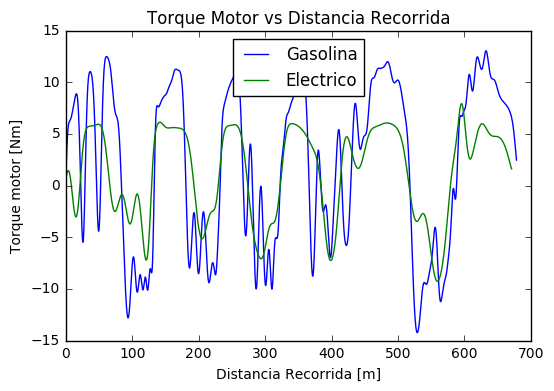

El torque máximo del Electrico es de 7.92Nm
El torque máximo del motor de gasolina es de 13.04Nm


In [32]:
plt.plot(gas.Distancia,TmotorG,label='Gasolina')
plt.plot(ele.Distancia,TmotorE,label='Electrico')
plt.legend(loc=9)
plt.title('Torque Motor vs Distancia Recorrida')
plt.xlabel('Distancia Recorrida [m]')
plt.ylabel('Torque motor [Nm]')
plt.show()
print('El torque máximo del Electrico es de %.2fNm' %max(TmotorE))
print('El torque máximo del motor de gasolina es de %.2fNm'%max(TmotorG))

De la anterior grafica se observa claramente la diferencia entre el torque entregado por el motor de gasolina y por el motro Electrico. Puesto que el maximo del motor de gasolina es de 7.92 Nm mientras que el electronico solo alcanza 7.92 Nm. No es posible decir que este valor afecta directamente a la aceleracion y puede observar que a pesar de que tener un factor de relación de cambio diferente el motor este motor aun es capaz de entregar un alto torque. El resultado del kart de gasolina muestra una mayor cantidad de oscilaciones que el motor Electrico. Esto se puede causar por ruido que no se logro quitar con el filtro. No obstante por no querer perder informacion no se quiso hacer un filtro mayor.    

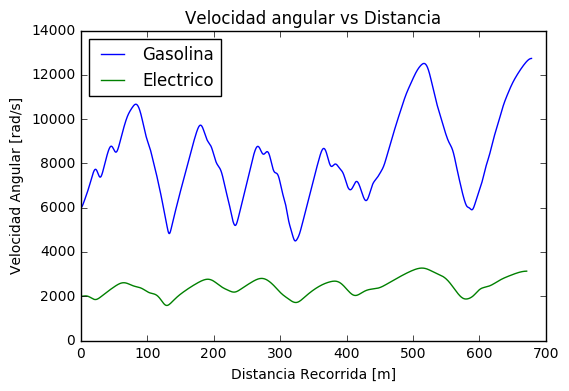

In [33]:
plt.plot(gas.Distancia,rpmG,label='Gasolina')
plt.plot(ele.Distancia,rpmE,label='Electrico')
plt.legend(loc=2)
plt.title('Velocidad angular vs Distancia')
plt.xlabel('Distancia Recorrida [m]')
plt.ylabel('Velocidad Angular [rad/s]')
plt.show()

Esta grafica muestra que en todo momento la velocidad del motor del kart de gasolina va mucho mas rapido que el motro electrico. Esto se explica por el tipo de motro y por el hecho que se tiene una mayor relación y por ente para generar el torque en las llantas se necesita una mayor velocidad. Por otro lado los valores del kart electrico muestra que la velocidad no se acerca a la velocidad maxima del motro de 5000 rpm. Esto muestra una capacidad para aprovechar mejor el motor que se tiene pero con otra relacion de cambios que genere mayor fuerza de traccion en las llantas con un menor esfuerzo del motor. 

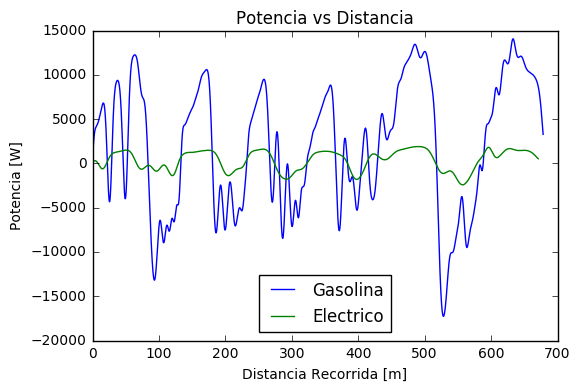

In [40]:
plt.plot(gas.Distancia,PG,label='Gasolina')
plt.plot(ele.Distancia,PE,label='Electrico')
plt.legend(loc=8)
plt.title('Potencia vs Distancia')
plt.xlabel('Distancia Recorrida [m]')
plt.ylabel('Potencia [W]')
plt.show()

Finalmente esta grafica es la grafica que demuestra de una manera más clara porque el kart de gasolina se ahorra 3 segundos. Su potencia en la mayoria del tiempo es más de 3 veces la potencia del kart electrico. Claramente esta potencia se puede llevar a energia cinetica que genera los perfiles de velocidad que se vieron anteriormente. 

# Conclusiones y mejoras. 

Del anterior taller se observa que en realidad el kart electrico tiene un rendimiento menor al de gasolina bajo todas las variables. Esto es de esperarse puesto que las capacidades de los motores de combustion interna en compracacion con las de los motores electricos.

Ahora bien si hay ciertos puntos que se pueden mejorar. 
Primero se recomiendo que si se van a hacer pruebas para comparar 2 karts es necesario que se haga el mismo recorrido. De otras formas es incorrecto compara cosas como tiempos de vueltas o velocidades maximas, ya que esta depende del recorrido. 

Para la seccion que se uso, la cual efectivamente se puede comparar. Es posible recomendar lo siguiente. 

El kart electrico no llega ni al limite de velocidad maxima ni el limite de velocidad angular maxima. Para esto se recomienda aumentar la relación. De tal manera que se pueda generar una aceleracion mayor. Es decir que se pueda llegar a la velocidad maxima de una forma más rapida, y por otro lado se aprovecharia mejor el motor. Así aumentando la Potencia entregada. 